# LiRA (Likelihood Ratio Attack) with PrivacyGuard for CIFAR-10

## Introduction

This tutorial demonstrates how to use the Privacy Guard framework to perform Likelihood Ratio Attacks (LiRA) on machine learning models trained on the CIFAR-10 dataset. We'll cover both online and offline variants of the attack. For more details, refer to the paper: https://arxiv.org/pdf/2112.03570.

### What is a Likelihood Ratio Attack (LiRA)?

LiRA is a powerful membership inference attack that uses the likelihood ratio test to determine whether a specific data point was used to train a machine learning model. Unlike simpler attacks that rely on a single threshold, LiRA uses multiple shadow models to estimate the distribution of model outputs for members and non-members of the training set.

### Online vs. Offline LiRA

- **Online LiRA**: Uses shadow models trained both with and without the target examples to estimate the likelihood distributions.
- **Offline LiRA**: Uses only shadow models trained without the target examples, making it more practical in real-world scenarios where attackers don't have access to models trained with specific examples.

### What We'll Cover

In this tutorial, we will:
1. Set up the CIFAR-10 dataset and create training/testing splits
2. Train a target model and multiple shadow models
3. Extract logits from all models
4. Perform both online and offline LiRA attacks using Privacy Guard's `LiraAttack` class
5. Analyze the attack results and evaluate privacy risks
6. Compare the effectiveness of online and offline attacks

Let's get started!

## Environment Set-Up


In [ ]:
# Optionally create a conda environment for installing packages.
# If executing from Google Colab, skip this step.
!conda create -n privacy_guard python=3.12
!conda activate privacy_guard


In [ ]:
%cd /content
!git clone https://github.com/facebookresearch/PrivacyGuard.git

In [ ]:
%cd /content/PrivacyGuard
!ls
!pip install -e .

## Setup and Imports

First, let's import the necessary libraries and set up our environment.

In [ ]:
from typing import Any, Dict, List, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from numpy.typing import NDArray

from privacy_guard.analysis.aggregate_analysis_input import AggregationType
from privacy_guard.attacks.lira_attack import LiraAttack
from privacy_guard.shadow_model_training import (
    analyze_attack,
    create_model,
    create_shadow_datasets,
    get_transformed_logits,
    load_cifar10,
    plot_roc_curve,
    plot_score_distributions,
    prepare_lira_data,
    train_model,
)
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import CIFAR10

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Use CUDA if available
DEVICE: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

I0730 132535.751 import_path_provider.py:123] Processing buck query results {"fbcode//privacy_guard/shadow_model_training:model": {"base_module": null, "platform_srcs": [], "srcs": {"model.py": "fbcode//privacy_guard/shadow_model_training/model.py"}, "versioned_srcs": null}, "fbcode//privacy_guard/shadow_model_training:test_dataset-library": {"base_module": null, "platform_srcs": [], "srcs": {"tests/test_dataset.py": "fbcode//privacy_guard/shadow_model_training/tests/test_dataset.py"}, "versioned_srcs": null}, "fbcode//privacy_guard/shadow_model_training:dataset": {"base_module": null, "platform_srcs": [], "srcs": {"dataset.py": "fbcode//privacy_guard/shadow_model_training/dataset.py"}, "versioned_srcs": null}, "fbcode//privacy_guard/shadow_model_training:test_training-library": {"base_module": null, "platform_srcs": [], "srcs": {"tests/test_training.py": "fbcode//privacy_guard/shadow_model_training/tests/test_training.py"}, "versioned_srcs": null}}
I0730 132535.952 _utils_internal.py:

Using device: cuda


## Dataset Preparation

Now, let's load the CIFAR-10 dataset and prepare it for our experiments.

In [ ]:
# Load the dataset
train_dataset: CIFAR10
test_dataset: CIFAR10
train_dataset, test_dataset = load_cifar10()
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

## Creating Shadow Datasets

For LiRA, we need to create multiple shadow datasets. Each shadow model will be trained on a different subset of the training data.

In [ ]:
# Create shadow datasets
num_shadows: int = 8  # Using fewer shadows for tutorial speed
shadow_datasets: List[Tuple[Subset, NDArray[np.float64]]]
target_dataset: Tuple[Subset, NDArray[np.float64]]
shadow_datasets, target_dataset = create_shadow_datasets(
    train_dataset, n_shadows=num_shadows
)

# Print shadow dataset sizes
for i, (shadow_in, _) in enumerate(shadow_datasets):
    print(f"Shadow {i}: {len(shadow_in)} in-samples")

print(
    f"Target: {len(target_dataset[0])} in-samples, {len(target_dataset[1])} out-samples"
)

Shadow 0: 24734 in-samples
Shadow 1: 25019 in-samples
Shadow 2: 24820 in-samples
Shadow 3: 24996 in-samples
Shadow 4: 25126 in-samples
Shadow 5: 24956 in-samples
Shadow 6: 25130 in-samples
Target: 25219 in-samples, 50000 out-samples


## Training Target and Shadow Models

Let's train our target model and shadow models.

In [ ]:
# Create data loaders
batch_size: int = 256
test_loader: DataLoader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

EPOCHS: int = 50
# Train target model (using target_in samples)
print("Training target model...")
target_model: nn.Module = create_model().to(DEVICE)
target_in: Subset = target_dataset[0]
target_loader: DataLoader = DataLoader(
    target_in, batch_size=batch_size, shuffle=True, num_workers=2
)
target_model = train_model(
    target_model, target_loader, test_loader, epochs=EPOCHS, device=DEVICE
)

# Train shadow models
shadow_models: List[nn.Module] = []
for i, (shadow_in, _) in enumerate(shadow_datasets):
    print(f"Training shadow model {i+1}/{len(shadow_datasets)}...")
    shadow_loader = DataLoader(
        shadow_in, batch_size=batch_size, shuffle=True, num_workers=2
    )
    shadow_model = create_model().to(DEVICE)
    shadow_model = train_model(
        shadow_model, shadow_loader, test_loader, epochs=EPOCHS, device=DEVICE
    )
    shadow_models.append(shadow_model)

Training target model...
Epoch 1/50
Training - Loss: 1.9200, Acc: 26.23%
Testing - Acc: 37.77%
Epoch 2/50
Training - Loss: 1.5382, Acc: 41.77%
Testing - Acc: 46.64%
Epoch 3/50
Training - Loss: 1.3475, Acc: 50.28%
Testing - Acc: 49.62%
Epoch 4/50
Training - Loss: 1.2015, Acc: 56.21%
Testing - Acc: 56.81%
Epoch 5/50
Training - Loss: 1.0752, Acc: 61.17%
Testing - Acc: 61.00%
Epoch 6/50
Training - Loss: 0.9701, Acc: 65.39%
Testing - Acc: 64.79%
Epoch 7/50
Training - Loss: 0.8956, Acc: 68.11%
Testing - Acc: 61.28%
Epoch 8/50
Training - Loss: 0.8352, Acc: 70.22%
Testing - Acc: 68.28%
Epoch 9/50
Training - Loss: 0.7735, Acc: 72.45%
Testing - Acc: 67.16%
Epoch 10/50
Training - Loss: 0.7155, Acc: 74.71%
Testing - Acc: 69.91%
Epoch 11/50
Training - Loss: 0.6662, Acc: 76.70%
Testing - Acc: 73.41%
Epoch 12/50
Training - Loss: 0.6293, Acc: 77.96%
Testing - Acc: 73.11%
Epoch 13/50
Training - Loss: 0.5910, Acc: 79.35%
Testing - Acc: 74.81%
Epoch 14/50
Training - Loss: 0.5527, Acc: 80.73%
Testing - Ac

## Extracting Logits

Now, let's extract logits from all models for the entire training dataset. These logits will be used for the LiRA attack.

In [ ]:
# Create a DataLoader for the entire training dataset (without shuffling)
train_eval_loader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

# Get logits from target model
print("Getting logits from target model...")
target_logits: NDArray[np.float64] = get_transformed_logits(
    target_model, train_eval_loader, DEVICE
)

# Get logits from shadow models
shadow_logits_list: List[NDArray[np.float64]] = []
num_shadows = len(shadow_models)
for i, shadow_model in enumerate(shadow_models):
    print(f"Getting logits from shadow model {i+1}/{num_shadows}...")
    shadow_logits_list.append(
        get_transformed_logits(shadow_model, train_eval_loader, DEVICE)
    )

shadow_logits: NDArray[np.float64] = np.array(shadow_logits_list)

Getting logits from target model...
Model accuracy: 0.9070
Getting logits from shadow model 1/7...
Model accuracy: 0.9108
Getting logits from shadow model 2/7...
Model accuracy: 0.9088
Getting logits from shadow model 3/7...
Model accuracy: 0.9088
Getting logits from shadow model 4/7...
Model accuracy: 0.9113
Getting logits from shadow model 5/7...
Model accuracy: 0.9087
Getting logits from shadow model 6/7...
Model accuracy: 0.9052
Getting logits from shadow model 7/7...
Model accuracy: 0.9095


## Preparing Data for LiRA Attack

Now, let's prepare the data for the LiRA attack using the Privacy Guard framework.

In [ ]:
# Prepare data for LiRA attack
df_train_online: pd.DataFrame
df_test_online: pd.DataFrame
df_train_offline: pd.DataFrame
df_test_offline: pd.DataFrame
df_train_online, df_test_online, df_train_offline, df_test_offline = prepare_lira_data(
    target_logits, shadow_logits, target_dataset, shadow_datasets
)

print(f"Training data shape: {df_train_online.shape}")
print(f"Testing data shape: {df_test_online.shape}")

Training data shape: (25219, 6)
Testing data shape: (24781, 6)


## Performing LiRA Attacks

Now, let's perform both online and offline LiRA attacks using the Privacy Guard framework.

In [ ]:
# Online LiRA attack
online_lira_attack = LiraAttack(
    df_train_merge=df_train_online,
    df_test_merge=df_test_online,
    row_aggregation=AggregationType.NONE,
    use_fixed_variance=True,
    std_dev_type="mix",
    online_attack=True,
)

# Run the attack
online_attack_results: Any = online_lira_attack.run_attack()

# Offline LiRA attack
offline_lira_attack = LiraAttack(
    df_train_merge=df_train_offline,
    df_test_merge=df_test_offline,
    row_aggregation=AggregationType.NONE,
    use_fixed_variance=True,
    std_dev_type="shadows_out",
    online_attack=False,
)

# Run the attack
offline_attack_results: Any = offline_lira_attack.run_attack()

## Analyzing Attack Results

Let's analyze the results of our attacks using the `AnalysisNode` class.

In [ ]:
# Analyze online attack
online_analysis: Dict[str, Any] = analyze_attack(online_attack_results, "Online LiRA")

# Analyze offline attack
offline_analysis: Dict[str, Any] = analyze_attack(
    offline_attack_results, "Offline LiRA"
)

I0730 141355.925 analysis_node.py:193] Train/Test unique users: 25219/24781
I0730 141406.676 mia_results.py:247] TNR: 0.00557, FNR: 0.0, emp eps: 2.67625, tnr@fnr0.001: 0.01453, eps@fnr0.001: 0.01087, auc 0.61153 accuracy 0.57639, 
I0730 141406.678 analysis_node.py:202] Epsilon CI: 2.6762499262774795
I0730 141433.571 analysis_node.py:193] Train/Test unique users: 25219/24781



Online LiRA Attack Results:
Attack Accuracy: 0.5739 (95% CI: [0.5701, 0.5776])
Attack AUC: 0.6074 (95% CI: [0.6026, 0.6124])
Epsilon at TPR=1% (Upper Bound): 2.3769
Epsilon at TPR=1% (Lower Bound): 1.6004


I0730 141445.998 mia_results.py:221] TNR: 0.01574, FNR: 0.00791, emp eps: 0.34589, tpr@fpr0.001: 0.0021, eps@fpr0.001: -0.21705, auc 0.53072 accuracy 0.52373, 


I0730 141446.001 analysis_node.py:202] Epsilon CI: 0.34589410489045613



Offline LiRA Attack Results:
Attack Accuracy: 0.5235 (95% CI: [0.5192, 0.5276])
Attack AUC: 0.5297 (95% CI: [0.5246, 0.5345])
Epsilon at TPR=1% (Upper Bound): 1.1057
Epsilon at TPR=1% (Lower Bound): 0.5637


## Visualizing Attack Results

Let's visualize the distribution of scores for members and non-members for both attacks.

<Figure size 1000x600 with 0 Axes>

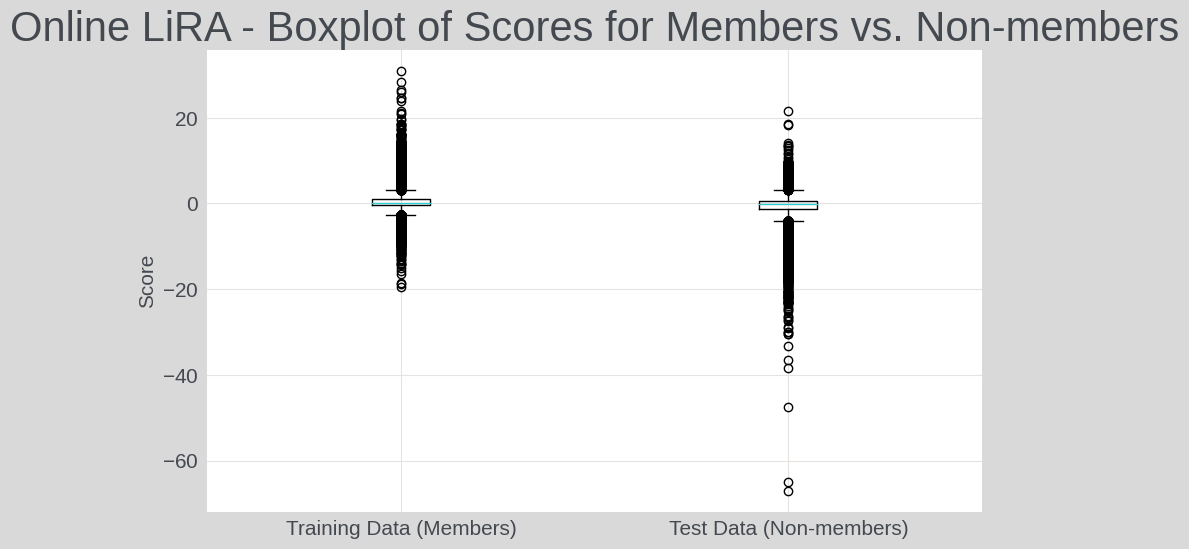

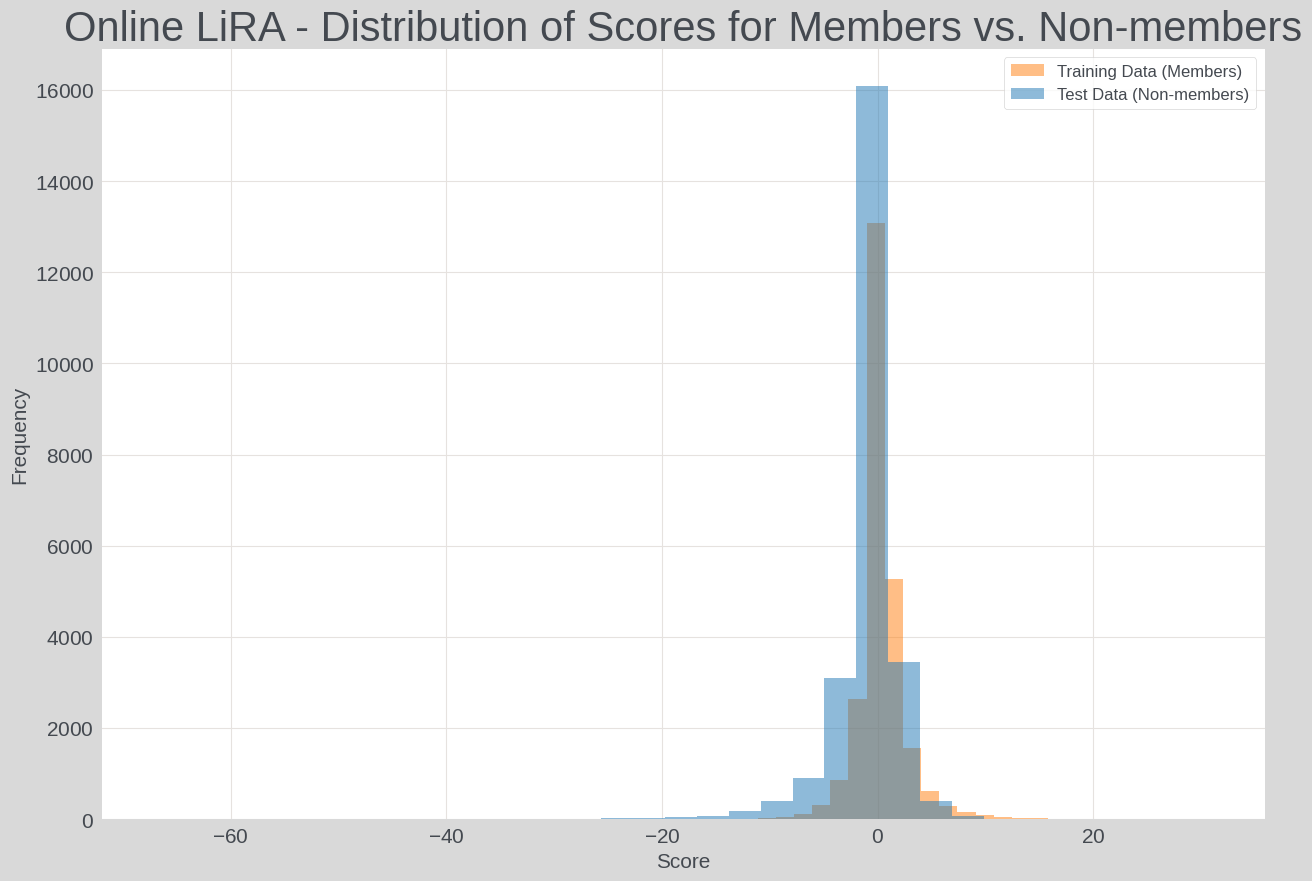

<Figure size 1000x600 with 0 Axes>

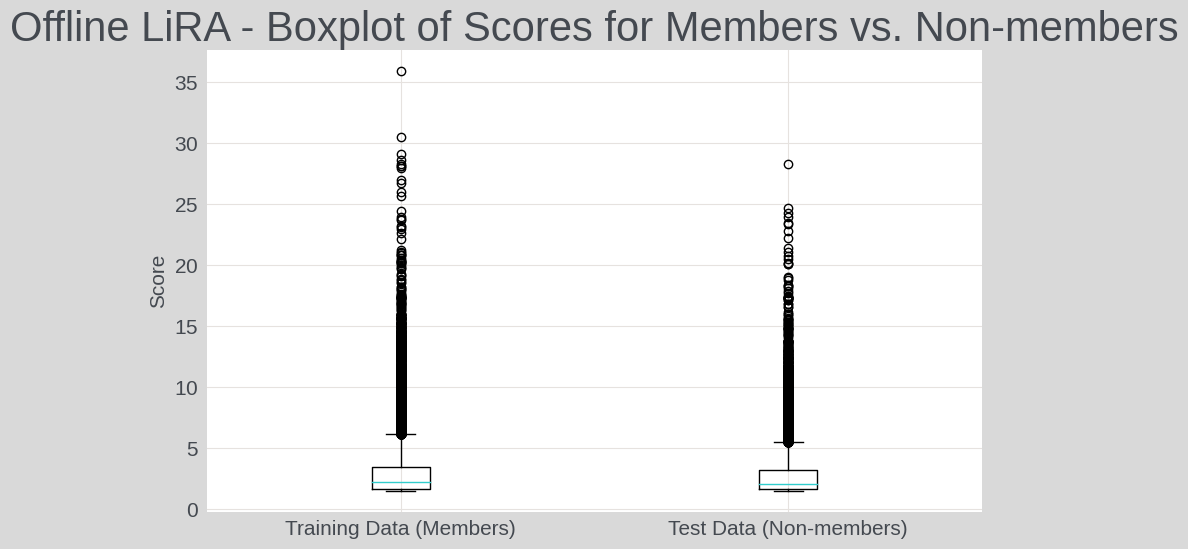

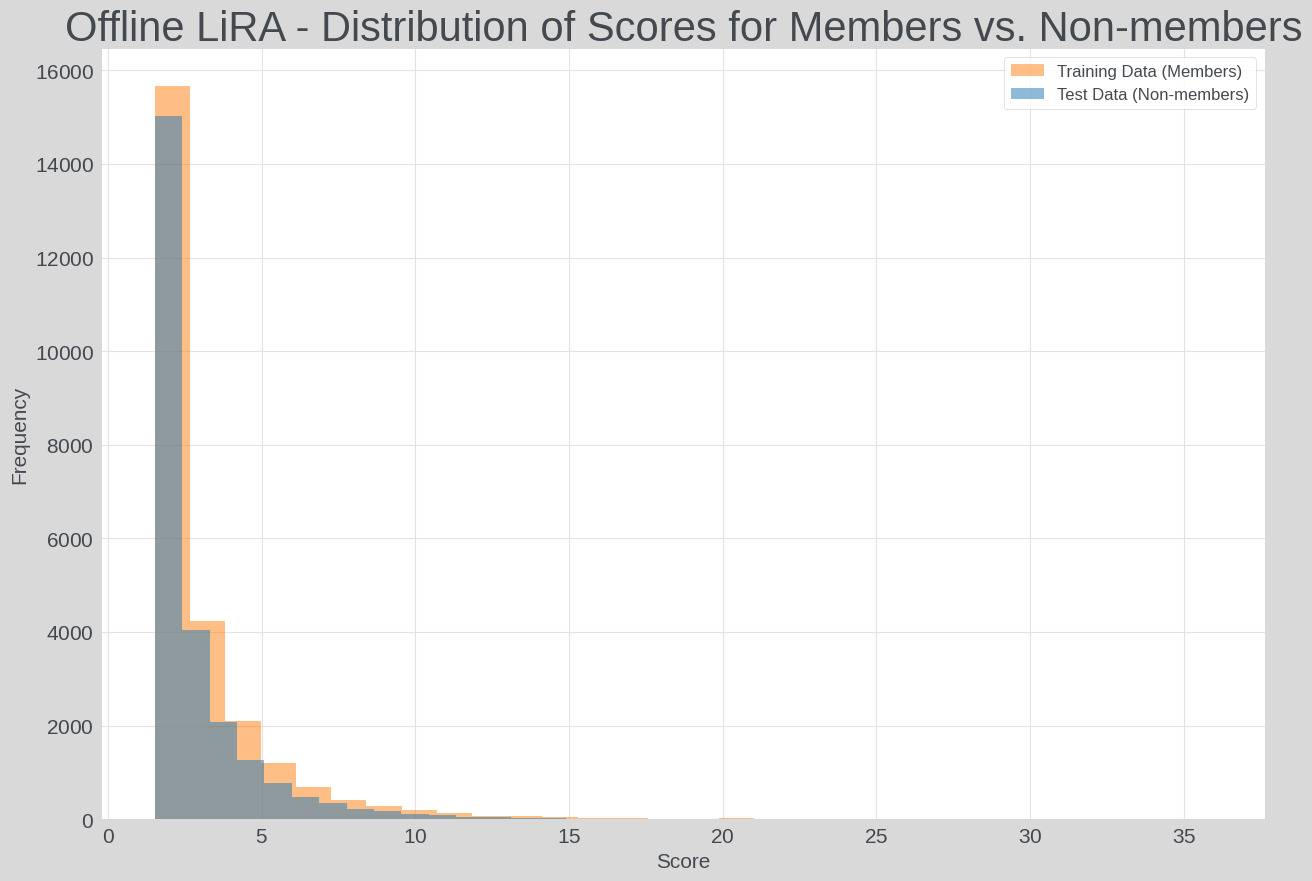

In [ ]:
# Plot score distributions
plot_score_distributions(online_attack_results, "Online LiRA")
plot_score_distributions(offline_attack_results, "Offline LiRA")

## Comparing ROC Curves

Let's compare the ROC curves for both attacks to visualize their performance.

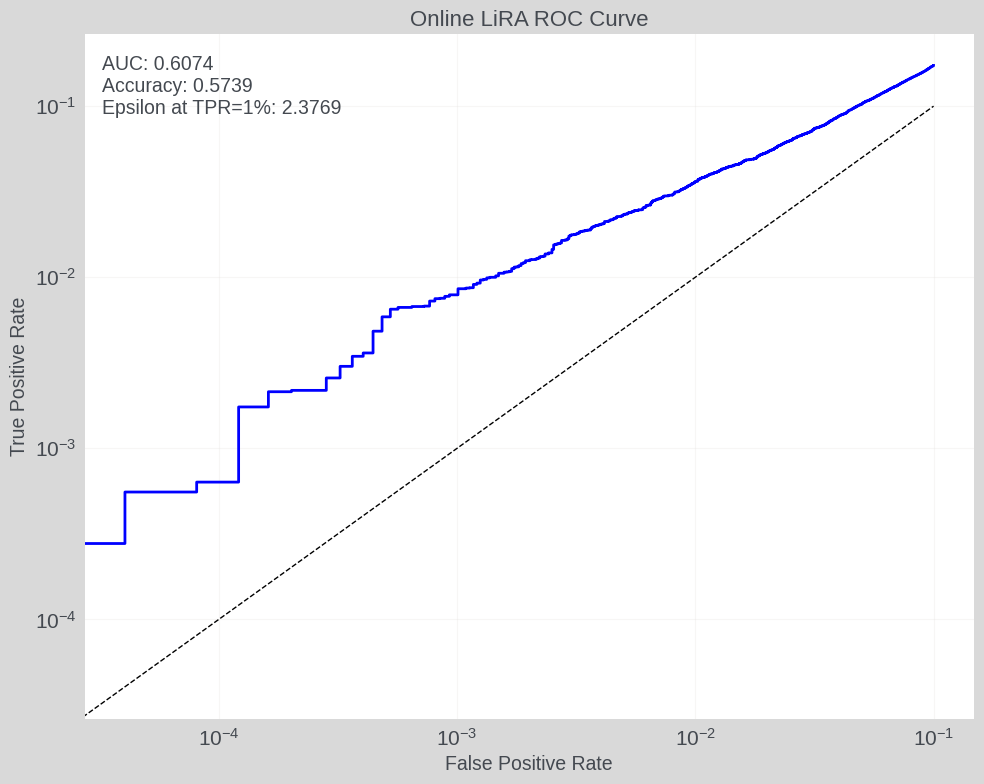

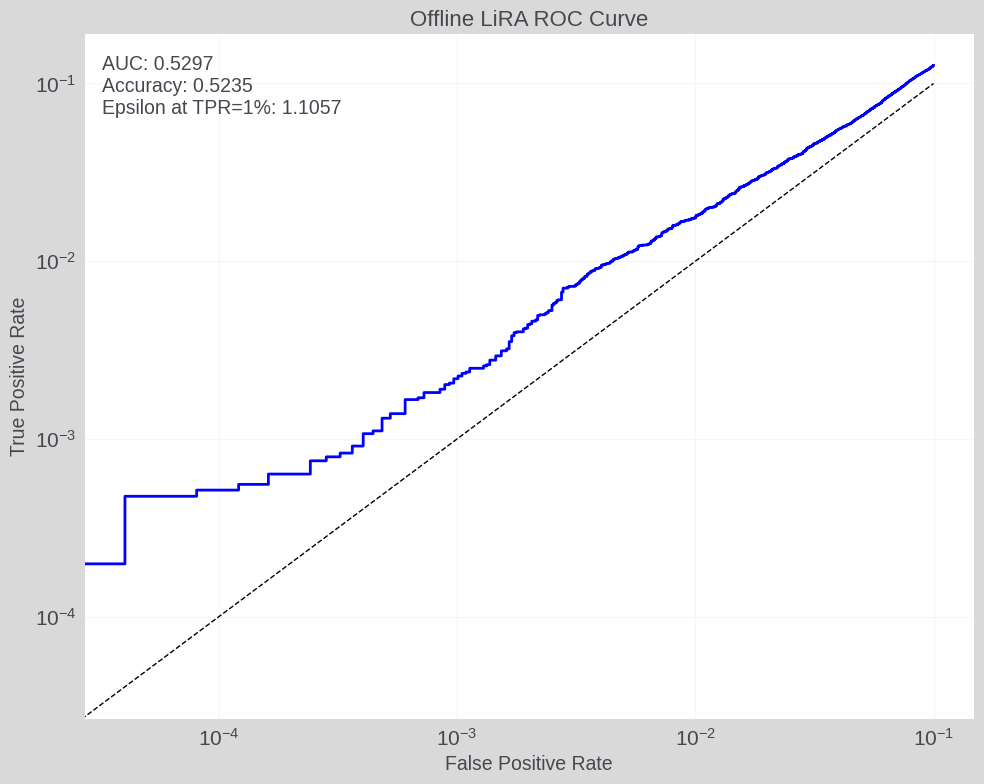

In [ ]:
# Plot ROC curves
plot_roc_curve(online_analysis, online_attack_results, title="Online LiRA")
plot_roc_curve(offline_analysis, offline_attack_results, title="Offline LiRA")

## Conclusion

In this tutorial, we demonstrated how to use the Privacy Guard framework to perform Likelihood Ratio Attacks (LiRA) on machine learning models trained on the CIFAR-10 dataset. We covered both online and offline variants of the attack and analyzed their effectiveness.

### Key Takeaways

1. **LiRA is a powerful membership inference attack** that uses multiple shadow models to estimate the distribution of model outputs for members and non-members.

2. **Online LiRA typically outperforms offline LiRA** because it has access to more information (shadow models trained both with and without target examples).

3. **Privacy Guard provides a comprehensive framework** for implementing and analyzing membership inference attacks, making it easier to assess the privacy risks of machine learning models.

### Mitigating Privacy Risks

To mitigate the privacy risks identified by LiRA attacks, consider the following approaches:

1. **Differential Privacy**: Train models with differential privacy guarantees to limit the influence of individual training examples.

2. **Regularization**: Apply stronger regularization techniques to reduce overfitting, which can help reduce the gap between model behavior on training and testing data.

3. **Model Pruning**: Reduce model complexity to prevent memorization of training data.

4. **Ensemble Methods**: Use ensemble methods to average predictions across multiple models, which can help reduce the variance in predictions.

By understanding and addressing these privacy risks, you can build more privacy-preserving machine learning models.